### Импорты

In [1]:
from LDANewsModel import LDANewsModel
from pyspark import SparkContext
from pyspark.sql import DataFrame, SparkSession

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Сессия Spark

In [2]:
sc = SparkContext('local[12]', 'LDAModel')
spark = SparkSession(sparkContext=sc)

# LDA на экономических новостях

## Загружаем данные

In [3]:
news_data = spark.read.parquet('data/russian_news.parquet').repartition(12).cache()
news_data.show(10)

+------+--------------------+
|    id|                text|
+------+--------------------+
|129268|
МОСКВА, 10 мар —...|
| 12026|МОСКВА, 28 янв - ...|
| 36225|МОСКВА, 23 мая — ...|
|125263|
МОСКВА, 10 апр —...|
| 43266|
МОСКВА, 29 ноя —...|
| 52730|
С.-ПЕТЕРБУРГ, 16...|
|128952|
МОСКВА, 12 мар —...|
| 90170|
МОСКВА, 19 апр —...|
| 47686|
МОСКВА, 29 авг —...|
| 35258|
МОСКВА, 5 июн — ...|
+------+--------------------+
only showing top 10 rows



## LDA модель


In [4]:
lda_model = LDANewsModel(news_data)
lda_results, vocab_model, predictions = lda_model.fit_predict()

Смотрим, что получилось

In [5]:
topics = lda_results.describeTopics(maxTermsPerTopic=15)
vocabulary = vocab_model.vocabulary
topics.show()
topics_rdd = topics.rdd
topics_words = topics_rdd.map(lambda row: row['termIndices']).map(
    lambda idx_list: [vocabulary[idx] for idx in idx_list]
).collect()

for idx, topic in enumerate(topics_words):
    print(f'Тема {idx + 1}')
    print('----------------')
    for word in topic:
        print(word)
    print('----------------')

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[26, 50, 32, 73, ...|[0.01794294330264...|
|    1|[2, 19, 66, 117, ...|[0.01069154561041...|
|    2|[25, 44, 51, 101,...|[0.01012439652392...|
|    3|[16, 13, 81, 104,...|[0.00642517037704...|
|    4|[0, 6, 42, 18, 3,...|[0.00754060413273...|
+-----+--------------------+--------------------+

Тема 1
----------------
индекс
баррел
пункт
торг
рубл
валют
аналитик
акц
доллар
добыч
ммвб
курс
цен
прогноз
сниз
----------------
Тема 2
----------------
состав
ставк
доход
инфляц
минфин
год
бюджет
триллион
перв
кредит
прогноз
кредитн
налогов
увелич
сниз
----------------
Тема 3
----------------
украин
поставк
росс
крым
экономическ
газпр
газ
товар
соглашен
российск
поток
переговор
газпром
украинск
поставок
----------------
Тема 4
----------------
строительств
предприят
суд
роснефт
крупн
завод
групп
оа
нов
директор
перв
авиакомпан
одн
котор
акти

## Сохраняем модель

In [6]:
predictions.select('*').repartition(1).write.parquet('predictions.parquet', mode='overwrite', compression='GZIP')

In [11]:
predictions_df = pd.read_parquet('predictions.parquet/part-00000-32be9d25-345b-4227-8f14-3c0c5da52977-c000.gz.parquet')[['id', 'stemmed_words','topicDistribution.values']]
predictions_df['predicted_topic'] = predictions_df['topicDistribution.values'].map(np.argmax)

In [12]:
inflation_df = pd.read_csv('data/russian_frame.csv')[['id', 'text']]
inflation_df

,id,text
0,1,"МОСКВА, 17 ноября/ Радио Sputnik. Белоруссия р..."
1,3,"ДУБАЙ, 17 ноя - РИА Новости. Министр промышлен..."
2,4,"МИНСК, 17 ноя - РИА Новости. Белоруссия рассчи..."
3,5,"МИНСК, 17 ноя — РИА Новости. Напряженные отнош..."
4,6,"МОСКВА, 17 ноя — РИА Новости. Эксперт по финан..."
...,...,...
104842,181653,"Премьер-министр РФ Дмитрий Медведев считает, ч..."
104843,181765,Госдума ратифицировала протокол о присоединени...
104844,182043,На встрече Путина и Титова речь шла о внесении...
104845,182433,Президент РФ Владимир Путин 28 июня представил...


In [13]:
def check_inflation(text):
    if 'рост цен' in text:
        return 1
    else:
        return 0
inflation_df['related'] = inflation_df.text.map(check_inflation)

In [14]:
inflation_df[inflation_df.related == 1]

,id,text,related
26,35,"МОСКВА, 15 ноя - РИА Новости. Федеральная анти...",1
117,171,"МОСКВА, 13 ноя - РИА Новости. Росстат продолжа...",1
172,261,"МОСКВА, 12 ноя - РИА Новости. Дефицита гречихи...",1
270,446,"МОСКВА, 7 ноя - РИА Новости. Укрепление рубля ...",1
272,450,"МОСКВА, 7 ноя - РИА Новости. Федеральная антим...",1
...,...,...,...
104405,177281,"\nБЛАГОВЕЩЕНСК, 30 окт - РИА Новости, Светлана...",1
104455,177373,"\nМОСКВА, 26 окт - РИА Новости. Индекс цен про...",1
104604,177612,"\nМОСКВА, 23 окт - РИА Новости. Государственны...",1
104653,177702,"\nМОСКВА, 19 окт - РИА Новости. Стоимость прое...",1


In [15]:
test = inflation_df.merge(predictions_df[['id', 'predicted_topic']], on='id', how='left')

In [16]:
test[test.related == 1].predicted_topic.value_counts()

1    669
4    218
0    165
2    127
3     53
Name: predicted_topic, dtype: int64

<AxesSubplot:>

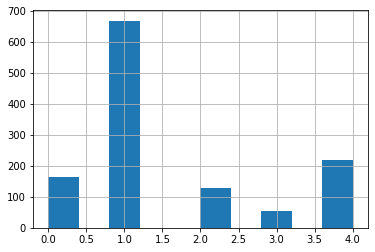

In [22]:
test[test.related == 1].predicted_topic.hist()

In [17]:
test[test.predicted_topic == 1].iloc[:10]

,id,text,related,predicted_topic
4,6,"МОСКВА, 17 ноя — РИА Новости. Эксперт по финан...",0,1
10,12,"МОСКВА, 17 ноя — РИА Новости. Россия прокладыв...",0,1
13,16,"МОСКВА, 16 ноя — РИА Новости. В России упал сп...",0,1
16,20,"МОСКВА, 16 ноя - РИА Новости. Россиянам для то...",0,1
36,48,"МОСКВА, 15 ноя - РИА Новости. Депутат Андрей М...",0,1
56,4286,"МОСКВА, 14 авг — РИА Новости. Рост потребитель...",0,1
68,112,"МОСКВА, 14 ноя — РИА Новости. Замминистра фина...",0,1
85,130,"МОСКВА, 14 ноя - РИА Новости. Последние два ме...",0,1
86,131,"МОСКВА, 14 ноя - РИА Новости. Средний срок ипо...",0,1
117,171,"МОСКВА, 13 ноя - РИА Новости. Росстат продолжа...",1,1


In [18]:
test[test.id == 119].text.values

array(['МОСКВА, 14 ноя — РИА Новости. Стоимость нового легкого самолета на замену кукурузника Ан-2 не должна превышать 120 миллионов рублей, а цена за час эксплуатации не должна быть больше 30 тысяч рублей, сообщает в четверг "Уральский завод гражданской авиации" (УЗГА).Конкурс на разработку этого самолета выиграла компания "Байкал-Инжиниринг", которая входит в состав УЗГА."Целевая стоимость самолета при серийном производстве не превышает 120 миллионов рублей в ценах 2020 года, а целевая себестоимость эксплуатации самолета в пересчете на летный час (без учета стоимости владения) — не более 30 тысяч рублей", — говорится в релизе.В пресс-службе рассказали, что Минпромторг задал требования, по многим параметрам превосходящие аналогичные характеристики Ан-2, а именно: расчетная крейсерская скорость полета — не менее 300 километров в час, расчетная практическая дальность полета с максимальной коммерческой нагрузкой — две тонны и с аварийным навигационным запасом на 45 минут полета — не мене

In [20]:
predictions_df[predictions_df.id == 35].stemmed_words.values

array([list(['федеральн', 'антимонопольн', 'фас', 'розничн', 'фас', 'андр', 'отвеч', 'соответств', 'указа', 'ведомств', 'вид', 'глобальн', 'пробл', 'дан', 'запас', 'плюс', 'урожа', 'полност', 'наш', 'потребн', 'никак', 'серьезн', 'пробл', 'должн', 'перв', 'втор', 'прежд', 'контрол', 'перв', 'плеч', 'производител', 'розниц', 'конкуренц', 'существ', 'люб', 'посмотрет', 'наскольк', 'замглав', 'фас', 'союз', 'предприят', 'рсмкп', 'опубликова', 'обращен', 'глав', 'фас', 'котор', 'происход', 'низк', 'текущ', 'антимонопольн', 'реш', 'провест', 'проверк', 'производител', 'фас', 'состоя', 'совещан', 'служб', 'представител', 'орган', 'управлен', 'апк', 'регион', 'ведомств', 'регион', 'основн', 'производител', 'культур', 'ситуац', 'наход', 'контрол', 'территориальн', 'дефицит', 'наблюда'])],
      dtype=object)